<a href="https://colab.research.google.com/github/Whoseyashar/Machine-Learning-Advance/blob/main/Biased_representation_with_Node2Vec.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Lets try to improve previous embeddings and predictions by biasing Random Walks using Node2Vec.


Node2Vec is an architecture largely based on DeepWalk. Node2Vec brings critical modifications to the way random walks themselves are generated. Node2Vec was introduced in 2016 by Grover and Leskovec from Stanford University. It keeps the same two main components from DeepWalk: random walks and Word2Vec. The difference is that instead of obtaining sequences of nodes with a uniform distribution, the random walks are carefully biased in Node2Vec.


The key concept introduced in Node2Vec is the flexible notion of a ***neighborhood***. But what is a ***neighborhood*** of a node? Intuitively, we think of it as something close to the initial node, but what does ***“close”*** mean in the context of a graph?

It means that different nodes in the neighborhood of a target node have different importance in its representation and to capture the importance we need to have an exploration process that is also called a sampling strategy.

Sampling strategies have opposite behaviors: Breadth-First Search (BFS) focuses on the local network around a node while Depth-First Search (DFS) establishes a more macro view of the graph. Considering our intuitive definition of a neighborhood, it is tempting to simply discard DFS. However, Node2Vec’s authors argue that this would be a mistake: each approach captures a different but valuable representation of the network.

They make a connection between these algorithms and two network properties:

Structural equivalence, which means that nodes are structurally equivalent if they share many of the same neighbors. So, if they share many neighbors, their structural equivalence is higher.
Homophily, as seen previously, states that similar nodes are more likely to be connected.

They argue that BFS is ideal to emphasize structural equivalence since this strategy only looks at neighboring nodes. In these random walks, nodes are often repeated and stay close to each other. DFS, on the other hand, emphasizes the opposite of homophily by creating sequences of distant nodes. These random walks can sample nodes that are far from the source and thus become less representative. This is why we’re looking for a trade-off between these two properties: homophily may be more helpful for understanding certain graphs and vice versa.

As a reminder, random walks are sequences of nodes that are randomly selected in a graph. They have a starting point, which can also be random, and a predefined length. Nodes that often appear together in these walks are like words that appear together in sentences: under the homophily hypothesis, they share a similar meaning, hence a similar representation.

In Node2Vec, our goal is to bias the randomness of these walks to either one of the following:

1. Promoting nodes that are not connected to the previous one (similar to DFS)
2. Promoting nodes that are close to the previous one (similar to BFS)


:Let's draw a graph with the following connections $j-i$, $j-k_1$, $j-k_2$, $i-k_1$. The walk starts from node $i$ and now arrives at node $j$. The probability of going back to the previous node $i$ is controlled by the parameter $p$. The higher it is, the more the random walk will explore new nodes instead of repeating the same ones and looking like DFS.
The unnormalized probability of going to $k_1$ is 1 because this node is in the immediate neighborhood of our previous node $i$.
Finally, the probability of going to node $k_2$ is controlled by the parameter $q$. The higher it is, the more the random walk will focus on nodes that are close to the previous one and look like BFS.

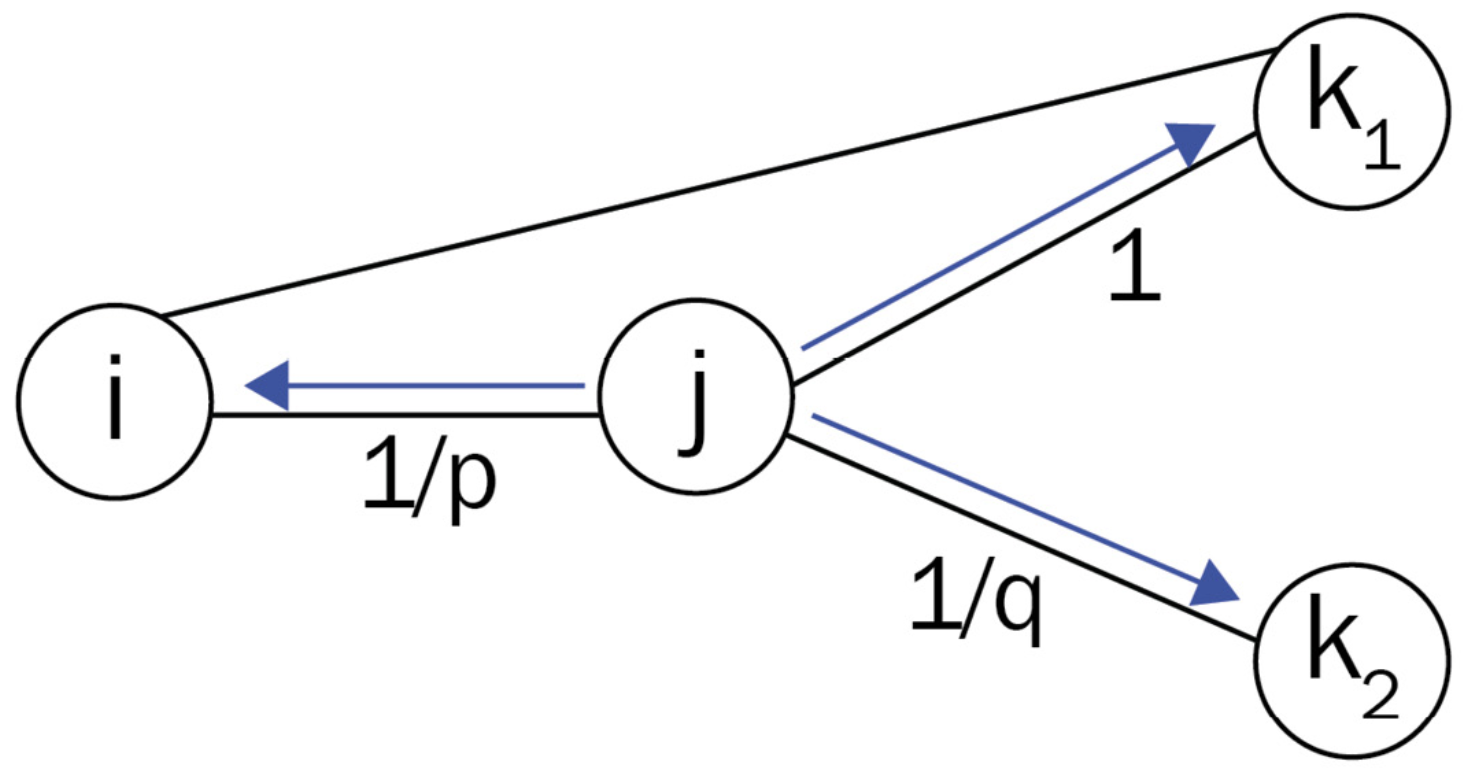


Let's implement biased random walk from scratch. But first let's generate a graph to test our biased random walk implementation.

/usr/local/lib/python3.10/dist-packages/networkx/drawing/nx_pylab.py:450: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  node_collection = ax.scatter(


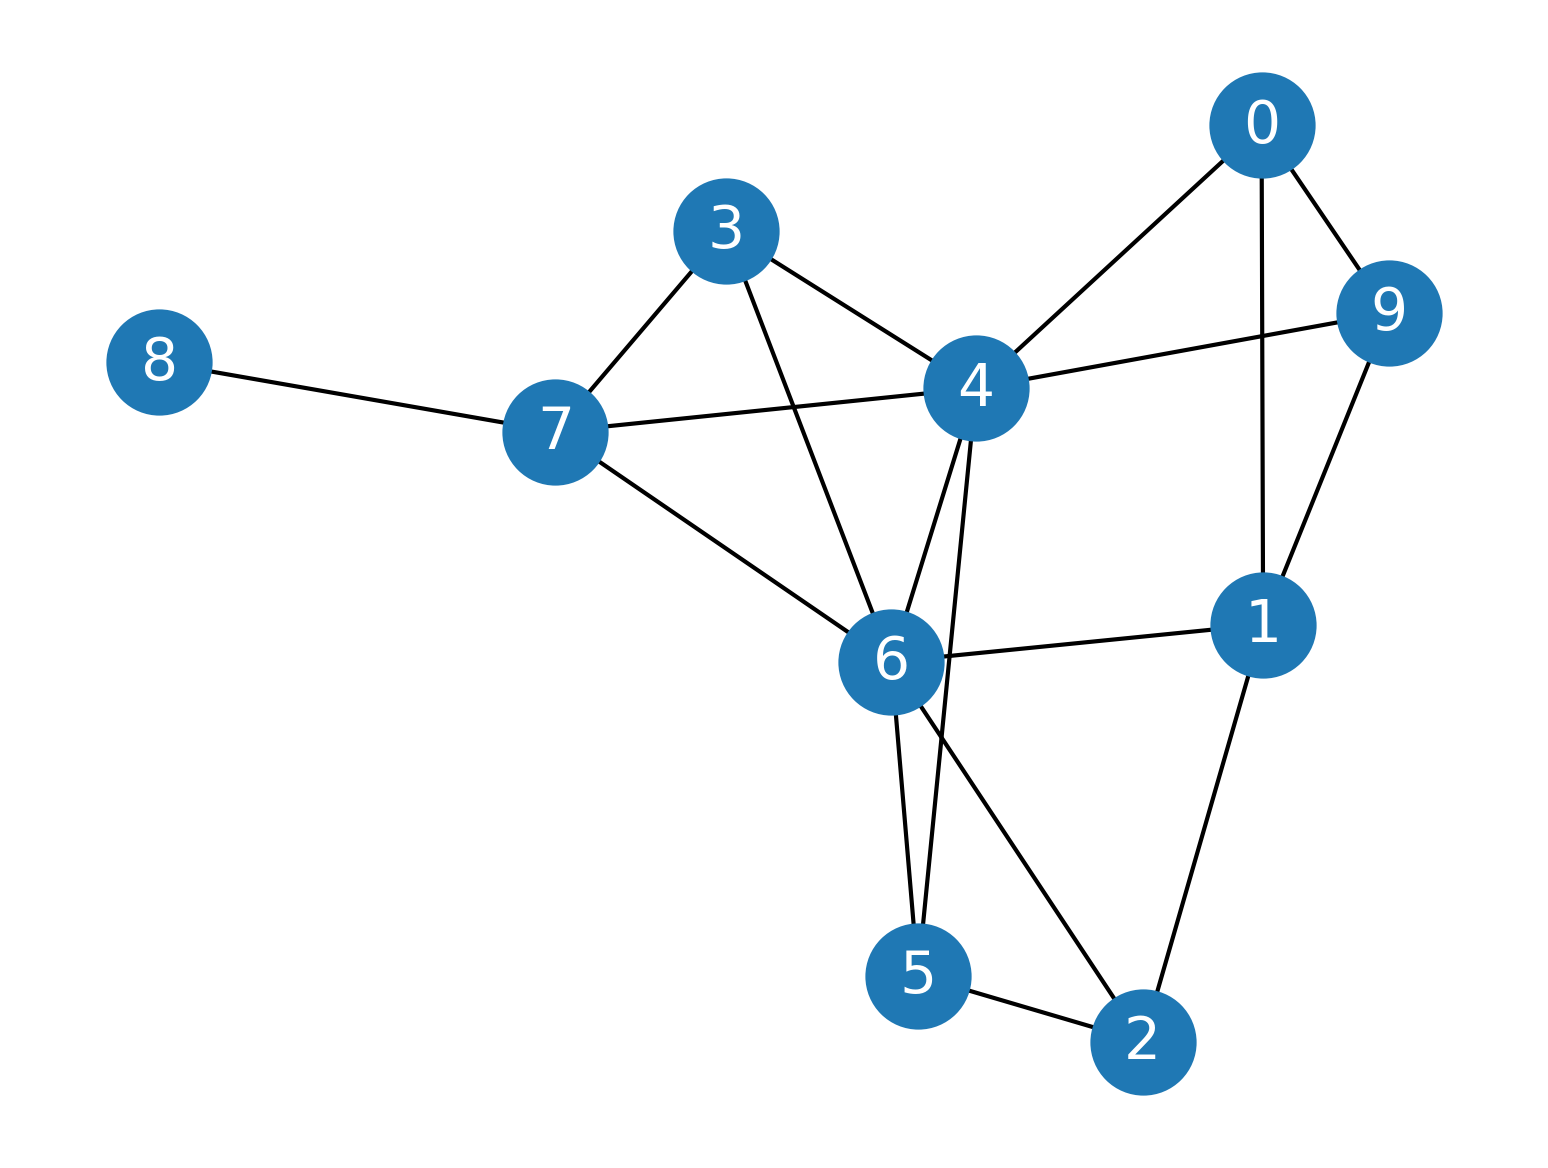

In [1]:
import networkx as nx
import random
import matplotlib.pyplot as plt

random.seed(0)
import numpy as np

G = nx.erdos_renyi_graph(10, 0.3, seed=1, directed=False)

plt.figure(dpi=300)
plt.axis('off')
nx.draw_networkx(G,
                 pos=nx.spring_layout(G, seed=0),
                 node_size=600,
                 cmap='coolwarm',
                 font_size=14,
                 font_color='white'
                 )
plt.show()

Now, we want to create a function that will randomly select the next node in a graph based on the previous node, the current node,and the two parameters $p$ and $q$. Such that we can randomly select the next node based on the transition probabilities.

In [2]:
def next_node(previous, current, p, q):
    neighbors = list(G.neighbors(current))
    alphas = []
    for neighbor in neighbors:
        if neighbor == previous:
            alpha = 1 / p
        elif G.has_edge(neighbor, previous):
            alpha = 1
        else:
            alpha = 1 / q
        alphas.append(alpha)

    probs = [alpha / sum(alphas) for alpha in alphas]
    next = np.random.choice(neighbors, size=1, p=probs)[0]
    return next

In [3]:
def random_walk(start, length, p, q):
    walk = [start]
    for i in range(length):
        current = walk[-1]
        previous = walk[-2] if len(walk) > 1 else None
        next = next_node(previous, current, p, q)
        walk.append(next)
    return [str(x) for x in walk]

## Exercise: Play with the parameters and observe the pattern in the walks
random_walk(0, 8, p=1, q=1)  # try p=50, q=100, and vice versa, what do you observe?

['0', '9', '0', '1', '6', '5', '4', '5', '4']

Now that we have the functions to generate biased random walks, the implementation of Node2Vec is very similar to implementing DeepWalk

In [4]:
from gensim.models.word2vec import Word2Vec
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

G = nx.karate_club_graph()

labels = []
for node in G.nodes:
    label = G.nodes[node]['club']
    labels.append(1 if label == 'Officer' else 0)

walks = []
for node in G.nodes:
    for _ in range(80):
        walks.append(random_walk(node, 10, 3, 2))

node2vec = Word2Vec(walks,
                    hs=1,  # Hierarchical softmax
                    sg=1,  # Skip-gram
                    vector_size=100,
                    window=10,
                    workers=2,
                    min_count=1,
                    seed=0)

node2vec.train(walks, total_examples=node2vec.corpus_count, epochs=30, report_delay=1)

train_mask = [2, 4, 6, 8, 10, 12, 14, 16, 18, 20, 22, 24]
train_mask_str = [str(x) for x in train_mask]
test_mask = [0, 1, 3, 5, 7, 9, 11, 13, 15, 17, 19, 21, 23, 25, 26, 27, 28, 29, 30, 31, 32, 33]
test_mask_str = [str(x) for x in test_mask]
labels = np.array(labels)

clf = RandomForestClassifier(random_state=0)
clf.fit(node2vec.wv[train_mask_str], labels[train_mask])

y_pred = clf.predict(node2vec.wv[test_mask_str])
acc = accuracy_score(y_pred, labels[test_mask])
print(f'Node2Vec accuracy = {acc * 100:.2f}%')

Node2Vec accuracy = 100.00%


***Task:*** Repeat the experiment 100 times, and take into consideration p and q values in the range [1,7[. Report mean.

In [5]:
def run(p,q):
  labels = []
  for node in G.nodes:
      label = G.nodes[node]['club']
      labels.append(1 if label == 'Officer' else 0)

  walks = []
  for node in G.nodes:
      for _ in range(80):
          walks.append(random_walk(node, 10, p, q))

  node2vec = Word2Vec(walks,
                      hs=1,  # Hierarchical softmax
                      sg=1,  # Skip-gram
                      vector_size=100,
                      window=10,
                      workers=2,
                      min_count=1,
                      seed=0)

  node2vec.train(walks, total_examples=node2vec.corpus_count, epochs=30, report_delay=1)

  train_mask = [2, 4, 6, 8, 10, 12, 14, 16, 18, 20, 22, 24]
  train_mask_str = [str(x) for x in train_mask]
  test_mask = [0, 1, 3, 5, 7, 9, 11, 13, 15, 17, 19, 21, 23, 25, 26, 27, 28, 29, 30, 31, 32, 33]
  test_mask_str = [str(x) for x in test_mask]
  labels = np.array(labels)

  clf = RandomForestClassifier(random_state=0)
  clf.fit(node2vec.wv[train_mask_str], labels[train_mask])

  y_pred = clf.predict(node2vec.wv[test_mask_str])
  acc = accuracy_score(y_pred, labels[test_mask])
  print(f'Node2Vec accuracy = {acc * 100:.2f}%')
  return acc

In [6]:
accs = []
for _ in range(100):
  p = np.random.randint(1,7)
  q = np.random.randint(1,7)
  acc=run(p,q)
  accs.append({"p":p,"q":q,"acc":acc})

Node2Vec accuracy = 81.82%


Node2Vec accuracy = 95.45%


Node2Vec accuracy = 100.00%


Node2Vec accuracy = 90.91%


Node2Vec accuracy = 95.45%


Node2Vec accuracy = 95.45%


Node2Vec accuracy = 90.91%


Node2Vec accuracy = 95.45%


Node2Vec accuracy = 90.91%


Node2Vec accuracy = 100.00%


Node2Vec accuracy = 95.45%


Node2Vec accuracy = 95.45%


Node2Vec accuracy = 100.00%


Node2Vec accuracy = 100.00%


Node2Vec accuracy = 95.45%


Node2Vec accuracy = 100.00%


Node2Vec accuracy = 95.45%


Node2Vec accuracy = 100.00%


Node2Vec accuracy = 100.00%


Node2Vec accuracy = 100.00%


Node2Vec accuracy = 95.45%


Node2Vec accuracy = 100.00%


Node2Vec accuracy = 100.00%


Node2Vec accuracy = 95.45%


Node2Vec accuracy = 95.45%


Node2Vec accuracy = 95.45%


Node2Vec accuracy = 95.45%


Node2Vec accuracy = 95.45%


Node2Vec accuracy = 100.00%


Node2Vec accuracy = 95.45%


Node2Vec accuracy = 95.45%


Node2Vec accuracy = 90.91%


Node2Vec accuracy = 100.00%


Node2Vec accuracy = 95.45%


Node2Vec accuracy = 95.45%


Node2Vec accuracy = 95.45%


Node2Vec accuracy = 95.45%


Node2Vec accuracy = 100.00%


Node2Vec accuracy = 100.00%


Node2Vec accuracy = 95.45%


Node2Vec accuracy = 100.00%


Node2Vec accuracy = 95.45%


Node2Vec accuracy = 95.45%


Node2Vec accuracy = 100.00%


Node2Vec accuracy = 90.91%


Node2Vec accuracy = 90.91%


Node2Vec accuracy = 100.00%


Node2Vec accuracy = 95.45%


Node2Vec accuracy = 86.36%


Node2Vec accuracy = 100.00%


Node2Vec accuracy = 90.91%


Node2Vec accuracy = 90.91%


Node2Vec accuracy = 90.91%


Node2Vec accuracy = 90.91%


Node2Vec accuracy = 86.36%


Node2Vec accuracy = 95.45%


Node2Vec accuracy = 95.45%


Node2Vec accuracy = 100.00%


Node2Vec accuracy = 95.45%


Node2Vec accuracy = 95.45%


Node2Vec accuracy = 90.91%


Node2Vec accuracy = 100.00%


Node2Vec accuracy = 95.45%


Node2Vec accuracy = 90.91%


Node2Vec accuracy = 95.45%


Node2Vec accuracy = 90.91%


Node2Vec accuracy = 100.00%


Node2Vec accuracy = 90.91%


Node2Vec accuracy = 100.00%


Node2Vec accuracy = 95.45%


Node2Vec accuracy = 100.00%


Node2Vec accuracy = 86.36%


Node2Vec accuracy = 100.00%


Node2Vec accuracy = 90.91%


Node2Vec accuracy = 100.00%


Node2Vec accuracy = 90.91%


Node2Vec accuracy = 90.91%


Node2Vec accuracy = 95.45%


Node2Vec accuracy = 95.45%


Node2Vec accuracy = 95.45%


Node2Vec accuracy = 90.91%


Node2Vec accuracy = 90.91%


Node2Vec accuracy = 90.91%


Node2Vec accuracy = 95.45%


Node2Vec accuracy = 95.45%


Node2Vec accuracy = 90.91%


Node2Vec accuracy = 95.45%


Node2Vec accuracy = 95.45%


Node2Vec accuracy = 90.91%


Node2Vec accuracy = 95.45%


Node2Vec accuracy = 95.45%


Node2Vec accuracy = 90.91%


Node2Vec accuracy = 90.91%


Node2Vec accuracy = 100.00%


Node2Vec accuracy = 95.45%


Node2Vec accuracy = 90.91%


Node2Vec accuracy = 90.91%


Node2Vec accuracy = 90.91%


Node2Vec accuracy = 90.91%


Node2Vec accuracy = 95.45%


***Task:*** Find the optimal p,q by repeating the experment 10 times and for each searching for optimal values of p and q in the range [1,7[

In [7]:
accs = []
for p in range(1,7):
  for q in range(1,7):
    for _ in range(10):
      acc=run(p,q)
      accs.append({"p":p,"q":q,"acc":acc})

Node2Vec accuracy = 90.91%


Node2Vec accuracy = 90.91%


Node2Vec accuracy = 95.45%


Node2Vec accuracy = 95.45%


Node2Vec accuracy = 90.91%


Node2Vec accuracy = 90.91%


Node2Vec accuracy = 90.91%


Node2Vec accuracy = 90.91%


Node2Vec accuracy = 95.45%


Node2Vec accuracy = 100.00%


Node2Vec accuracy = 90.91%


Node2Vec accuracy = 95.45%


Node2Vec accuracy = 90.91%


Node2Vec accuracy = 95.45%


Node2Vec accuracy = 95.45%


Node2Vec accuracy = 95.45%


Node2Vec accuracy = 90.91%


Node2Vec accuracy = 95.45%


Node2Vec accuracy = 90.91%


Node2Vec accuracy = 95.45%


Node2Vec accuracy = 86.36%


Node2Vec accuracy = 90.91%


Node2Vec accuracy = 90.91%


Node2Vec accuracy = 95.45%


Node2Vec accuracy = 100.00%


Node2Vec accuracy = 90.91%


Node2Vec accuracy = 95.45%


Node2Vec accuracy = 90.91%


Node2Vec accuracy = 95.45%


Node2Vec accuracy = 90.91%


Node2Vec accuracy = 95.45%


Node2Vec accuracy = 90.91%


Node2Vec accuracy = 90.91%


Node2Vec accuracy = 95.45%


Node2Vec accuracy = 95.45%


Node2Vec accuracy = 95.45%


Node2Vec accuracy = 95.45%


Node2Vec accuracy = 90.91%


Node2Vec accuracy = 90.91%


Node2Vec accuracy = 86.36%


Node2Vec accuracy = 95.45%


Node2Vec accuracy = 100.00%


Node2Vec accuracy = 100.00%


Node2Vec accuracy = 90.91%


Node2Vec accuracy = 95.45%


Node2Vec accuracy = 90.91%


Node2Vec accuracy = 90.91%


Node2Vec accuracy = 100.00%


Node2Vec accuracy = 95.45%


Node2Vec accuracy = 90.91%


Node2Vec accuracy = 90.91%


Node2Vec accuracy = 100.00%


Node2Vec accuracy = 90.91%


Node2Vec accuracy = 95.45%


Node2Vec accuracy = 95.45%


Node2Vec accuracy = 100.00%


Node2Vec accuracy = 95.45%


Node2Vec accuracy = 95.45%


Node2Vec accuracy = 95.45%


Node2Vec accuracy = 90.91%


Node2Vec accuracy = 100.00%


Node2Vec accuracy = 95.45%


Node2Vec accuracy = 90.91%


Node2Vec accuracy = 95.45%


Node2Vec accuracy = 95.45%


Node2Vec accuracy = 95.45%


Node2Vec accuracy = 95.45%


Node2Vec accuracy = 95.45%


Node2Vec accuracy = 90.91%


Node2Vec accuracy = 95.45%


Node2Vec accuracy = 95.45%


Node2Vec accuracy = 95.45%


Node2Vec accuracy = 90.91%


Node2Vec accuracy = 81.82%


Node2Vec accuracy = 90.91%


Node2Vec accuracy = 90.91%


Node2Vec accuracy = 100.00%


Node2Vec accuracy = 90.91%


Node2Vec accuracy = 100.00%


Node2Vec accuracy = 95.45%


Node2Vec accuracy = 95.45%


Node2Vec accuracy = 95.45%


Node2Vec accuracy = 95.45%


Node2Vec accuracy = 86.36%


Node2Vec accuracy = 95.45%


Node2Vec accuracy = 90.91%


Node2Vec accuracy = 95.45%


Node2Vec accuracy = 86.36%


Node2Vec accuracy = 95.45%


Node2Vec accuracy = 95.45%


Node2Vec accuracy = 90.91%


Node2Vec accuracy = 100.00%


Node2Vec accuracy = 90.91%


Node2Vec accuracy = 86.36%


Node2Vec accuracy = 95.45%


Node2Vec accuracy = 95.45%


Node2Vec accuracy = 95.45%


Node2Vec accuracy = 90.91%


Node2Vec accuracy = 95.45%


Node2Vec accuracy = 95.45%


Node2Vec accuracy = 95.45%


Node2Vec accuracy = 95.45%


Node2Vec accuracy = 95.45%


Node2Vec accuracy = 90.91%


Node2Vec accuracy = 100.00%


Node2Vec accuracy = 90.91%


Node2Vec accuracy = 86.36%


Node2Vec accuracy = 90.91%


Node2Vec accuracy = 95.45%


Node2Vec accuracy = 90.91%


Node2Vec accuracy = 86.36%


Node2Vec accuracy = 90.91%


Node2Vec accuracy = 95.45%


Node2Vec accuracy = 90.91%


Node2Vec accuracy = 100.00%


Node2Vec accuracy = 86.36%


Node2Vec accuracy = 90.91%


Node2Vec accuracy = 90.91%


Node2Vec accuracy = 100.00%


Node2Vec accuracy = 95.45%


Node2Vec accuracy = 95.45%


Node2Vec accuracy = 86.36%


Node2Vec accuracy = 90.91%


Node2Vec accuracy = 100.00%


Node2Vec accuracy = 90.91%


Node2Vec accuracy = 95.45%


Node2Vec accuracy = 100.00%


Node2Vec accuracy = 95.45%


Node2Vec accuracy = 100.00%


Node2Vec accuracy = 100.00%


Node2Vec accuracy = 95.45%


Node2Vec accuracy = 100.00%


Node2Vec accuracy = 100.00%


Node2Vec accuracy = 100.00%


Node2Vec accuracy = 100.00%


Node2Vec accuracy = 95.45%


Node2Vec accuracy = 95.45%


Node2Vec accuracy = 100.00%


Node2Vec accuracy = 100.00%


Node2Vec accuracy = 90.91%


Node2Vec accuracy = 100.00%


Node2Vec accuracy = 90.91%


Node2Vec accuracy = 95.45%


Node2Vec accuracy = 95.45%


Node2Vec accuracy = 100.00%


Node2Vec accuracy = 90.91%


Node2Vec accuracy = 90.91%


Node2Vec accuracy = 95.45%


Node2Vec accuracy = 100.00%


Node2Vec accuracy = 95.45%


Node2Vec accuracy = 90.91%


Node2Vec accuracy = 100.00%


Node2Vec accuracy = 95.45%


Node2Vec accuracy = 86.36%


Node2Vec accuracy = 95.45%


Node2Vec accuracy = 95.45%


Node2Vec accuracy = 95.45%


Node2Vec accuracy = 90.91%


Node2Vec accuracy = 90.91%


Node2Vec accuracy = 90.91%


Node2Vec accuracy = 95.45%


Node2Vec accuracy = 90.91%


Node2Vec accuracy = 95.45%


Node2Vec accuracy = 86.36%


Node2Vec accuracy = 100.00%


Node2Vec accuracy = 90.91%


Node2Vec accuracy = 90.91%


Node2Vec accuracy = 90.91%


Node2Vec accuracy = 100.00%


Node2Vec accuracy = 95.45%


Node2Vec accuracy = 90.91%


Node2Vec accuracy = 90.91%


Node2Vec accuracy = 90.91%


Node2Vec accuracy = 95.45%


Node2Vec accuracy = 90.91%


Node2Vec accuracy = 90.91%


Node2Vec accuracy = 95.45%


Node2Vec accuracy = 95.45%


Node2Vec accuracy = 95.45%


Node2Vec accuracy = 95.45%


Node2Vec accuracy = 90.91%


Node2Vec accuracy = 90.91%


Node2Vec accuracy = 100.00%


Node2Vec accuracy = 90.91%


Node2Vec accuracy = 90.91%


Node2Vec accuracy = 86.36%


Node2Vec accuracy = 95.45%


Node2Vec accuracy = 95.45%


Node2Vec accuracy = 95.45%


Node2Vec accuracy = 95.45%


Node2Vec accuracy = 100.00%


Node2Vec accuracy = 100.00%


Node2Vec accuracy = 95.45%


Node2Vec accuracy = 95.45%


Node2Vec accuracy = 95.45%


Node2Vec accuracy = 95.45%


Node2Vec accuracy = 90.91%


Node2Vec accuracy = 90.91%


Node2Vec accuracy = 90.91%


Node2Vec accuracy = 95.45%


Node2Vec accuracy = 95.45%


Node2Vec accuracy = 100.00%


Node2Vec accuracy = 100.00%


Node2Vec accuracy = 95.45%


Node2Vec accuracy = 95.45%


Node2Vec accuracy = 90.91%


Node2Vec accuracy = 100.00%


Node2Vec accuracy = 100.00%


Node2Vec accuracy = 95.45%


Node2Vec accuracy = 100.00%


Node2Vec accuracy = 100.00%


Node2Vec accuracy = 95.45%


Node2Vec accuracy = 95.45%


Node2Vec accuracy = 95.45%


Node2Vec accuracy = 100.00%


Node2Vec accuracy = 95.45%


Node2Vec accuracy = 90.91%


Node2Vec accuracy = 95.45%


Node2Vec accuracy = 90.91%


Node2Vec accuracy = 90.91%


Node2Vec accuracy = 90.91%


Node2Vec accuracy = 95.45%


Node2Vec accuracy = 95.45%


Node2Vec accuracy = 95.45%


Node2Vec accuracy = 95.45%


Node2Vec accuracy = 81.82%


Node2Vec accuracy = 90.91%


Node2Vec accuracy = 95.45%


Node2Vec accuracy = 95.45%


Node2Vec accuracy = 95.45%


Node2Vec accuracy = 100.00%


Node2Vec accuracy = 95.45%


Node2Vec accuracy = 90.91%


Node2Vec accuracy = 95.45%


Node2Vec accuracy = 100.00%


Node2Vec accuracy = 95.45%


Node2Vec accuracy = 100.00%


Node2Vec accuracy = 100.00%


Node2Vec accuracy = 95.45%


Node2Vec accuracy = 95.45%


Node2Vec accuracy = 90.91%


Node2Vec accuracy = 95.45%


Node2Vec accuracy = 100.00%


Node2Vec accuracy = 100.00%


Node2Vec accuracy = 86.36%


Node2Vec accuracy = 90.91%


Node2Vec accuracy = 95.45%


Node2Vec accuracy = 100.00%


Node2Vec accuracy = 90.91%


Node2Vec accuracy = 86.36%


Node2Vec accuracy = 90.91%


Node2Vec accuracy = 95.45%


Node2Vec accuracy = 95.45%


Node2Vec accuracy = 100.00%


Node2Vec accuracy = 100.00%


Node2Vec accuracy = 100.00%


Node2Vec accuracy = 90.91%


Node2Vec accuracy = 95.45%


Node2Vec accuracy = 100.00%


Node2Vec accuracy = 95.45%


Node2Vec accuracy = 95.45%


Node2Vec accuracy = 95.45%


Node2Vec accuracy = 95.45%


Node2Vec accuracy = 95.45%


Node2Vec accuracy = 100.00%


Node2Vec accuracy = 90.91%


Node2Vec accuracy = 100.00%


Node2Vec accuracy = 100.00%


Node2Vec accuracy = 100.00%


Node2Vec accuracy = 81.82%


Node2Vec accuracy = 100.00%


Node2Vec accuracy = 100.00%


Node2Vec accuracy = 100.00%


Node2Vec accuracy = 95.45%


Node2Vec accuracy = 86.36%


Node2Vec accuracy = 95.45%


Node2Vec accuracy = 95.45%


Node2Vec accuracy = 100.00%


Node2Vec accuracy = 95.45%


Node2Vec accuracy = 95.45%


Node2Vec accuracy = 100.00%


Node2Vec accuracy = 90.91%


Node2Vec accuracy = 90.91%


Node2Vec accuracy = 95.45%


Node2Vec accuracy = 100.00%


Node2Vec accuracy = 100.00%


Node2Vec accuracy = 95.45%


Node2Vec accuracy = 90.91%


Node2Vec accuracy = 100.00%


Node2Vec accuracy = 95.45%


Node2Vec accuracy = 90.91%


Node2Vec accuracy = 95.45%


Node2Vec accuracy = 95.45%


Node2Vec accuracy = 95.45%


Node2Vec accuracy = 95.45%


Node2Vec accuracy = 100.00%


Node2Vec accuracy = 90.91%


Node2Vec accuracy = 100.00%


Node2Vec accuracy = 90.91%


Node2Vec accuracy = 100.00%


Node2Vec accuracy = 90.91%


Node2Vec accuracy = 95.45%


Node2Vec accuracy = 95.45%


Node2Vec accuracy = 100.00%


Node2Vec accuracy = 90.91%


Node2Vec accuracy = 100.00%


Node2Vec accuracy = 90.91%


Node2Vec accuracy = 100.00%


Node2Vec accuracy = 90.91%


Node2Vec accuracy = 95.45%


Node2Vec accuracy = 95.45%


Node2Vec accuracy = 95.45%


Node2Vec accuracy = 100.00%


Node2Vec accuracy = 90.91%


Node2Vec accuracy = 100.00%


Node2Vec accuracy = 95.45%


Node2Vec accuracy = 90.91%


Node2Vec accuracy = 100.00%


Node2Vec accuracy = 100.00%


Node2Vec accuracy = 100.00%


Node2Vec accuracy = 95.45%


Node2Vec accuracy = 95.45%


Node2Vec accuracy = 95.45%


Node2Vec accuracy = 100.00%


Node2Vec accuracy = 100.00%


Node2Vec accuracy = 100.00%


Node2Vec accuracy = 90.91%


Node2Vec accuracy = 100.00%


Node2Vec accuracy = 90.91%


Node2Vec accuracy = 90.91%


Node2Vec accuracy = 100.00%


Node2Vec accuracy = 100.00%


Node2Vec accuracy = 100.00%


Node2Vec accuracy = 100.00%


Node2Vec accuracy = 95.45%


Node2Vec accuracy = 90.91%


Node2Vec accuracy = 100.00%


Node2Vec accuracy = 95.45%


Node2Vec accuracy = 100.00%


Node2Vec accuracy = 90.91%


Node2Vec accuracy = 90.91%


Node2Vec accuracy = 95.45%


Node2Vec accuracy = 90.91%


Node2Vec accuracy = 95.45%


Node2Vec accuracy = 95.45%


Node2Vec accuracy = 100.00%


Node2Vec accuracy = 95.45%


Node2Vec accuracy = 100.00%


Node2Vec accuracy = 90.91%


Node2Vec accuracy = 100.00%


Node2Vec accuracy = 100.00%


Node2Vec accuracy = 90.91%


Node2Vec accuracy = 90.91%


Node2Vec accuracy = 95.45%


Node2Vec accuracy = 95.45%


Node2Vec accuracy = 100.00%


Node2Vec accuracy = 86.36%


Node2Vec accuracy = 100.00%


Node2Vec accuracy = 95.45%


Node2Vec accuracy = 90.91%


In [8]:
import pandas as pd
df = pd.DataFrame(accs)

